<img src="https://crowdmark-com.s3.amazonaws.com/website/images/visual-identity/crowdmark-logo-dark.png" alt="PIMS logo" width ="180" align="right">

# Exploratory Analysis of Scores in a Course

[Crowdmark API Guide (draft version)](https://gist.github.com/heycarsten/46060b3cfce1eaeed325ddd3cdb79f0b)

[Draft Documentation Site](http://scattered-island.surge.sh/)

Goals: Use the Crowdmark API to
1. Access scores data for single assessment in a course
2. Loop over all assessments in a course to build scores data for the course
3. Explore scores data

### Install some tools

In [1]:
## Some math and data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import simplejson as json

In [2]:
# Import seaborn for visualizing data graphically
import seaborn as sns
sns.set()

In [3]:
## For graphing in this notebook
%matplotlib inline

## Crowdmark API key

**Please be careful here!**

> The Crowdmark API key is like a password and needs to be carefully protected. The API allows a user to programmatically access the data that the user can access through the Crowdmark GUI. The next two cells contain instructions for how to write the Crowdmark API key into a file called `.crowdmark_key` in the current directory. The `.crowdmark_key` file should not be shared publicly. That file should not be uploaded to any shared git repository. This repository includes `.crowdmark_key` in the `.gitignore` file. 


In [ ]:
## Execute this cell to generate a request for your API key.
## Paste your api key into the text field (and press enter); Comment out the next line to define your API Key.
# api = input("What is your Crowdmark API key:")

In [ ]:
## This cell writes the content of `api` to the file .crowdmark-key.

#with open(".crowdmark-key", "w") as text_file:
#   print(f"{api}", file=text_file)

In [4]:
# This cell reads in the .crowdmark-key file and saves it as apiKey.
# The API key allows the computer hosting your Jupyter notebook to programmatically access data from Crowdmark.
with open(".crowdmark-key", 'r') as f:
    apiKey = f.read().rstrip()
# apiKey

## Specify the Course

In [5]:
## SPECIFY THE COURSE YOU WISH TO INVESTIGATE HERE
# course_slug = 'demos'
course_slug ='samples'
## J. Colliander's course at UBC: MAT217 Multivariable and Vector Calculus
# course_slug = '2015mat127-7934f'
## C. Junkin's course at McMaster: MATH 1LS3:Calculus for the Life Sciences I (Spring 2021)
# course_slug = 'math-1ls3-calculus-for-the-life-sciences-i-math_1ls3_junkinc_2215'

In [6]:
## Define the URL endpoint for accessing the API data.
cm = 'https://app.crowdmark.com'
## WARNING: Some universities are hosted on the USA cluster.

## Some Crowdmark API endpoints
# api_endpoint = '/api/users/{user-id}'
# api_endpoint = '/api/courses/'
# api_endpoint = '/api/courses/2015mat127-7934f/assessments'
# api_endpoint = '/api/assessments'
# api_endpoint = '/api/assessments/mat217-assignment-4/enrollments'
# api_endpoint = '/api/assessments/mat217-assignment-4/memberships'
# api_endpoint = '/api/assessments/mat217-assignment-4/questions'
# booklets_endpoint = '/api/assessments/' + assessment_slug +'/booklets'
assessments_endpoint = '/api/courses/' + course_slug + '/assessments'
# enrollments_endpoint = '/api/assessments/' + assessment_slug + '/enrollments'
# bookletsURL = cm + booklets_endpoint + '?api_key=' + apiKey
assessmentsURL = cm + assessments_endpoint + '?api_key=' + apiKey
# enrollmentsURL = cm + enrollments_endpoint + '?api_key=' + apiKey


In [7]:
## Import the assessments data from the course

from urllib.request import urlopen

# booklets_response = urlopen(bookletsURL).read().decode('utf8')
# booklets = json.loads(booklets_response)

assessments_response = urlopen(assessmentsURL).read().decode('utf8')
assessments = json.loads(assessments_response)

# enrollments_response = urlopen(enrollmentsURL).read().decode('utf8')
# enrollments = json.loads(enrollments_response)

## Our data set has been pulled from bookletsURL and is now encoded as python dictionary in `booklets`.

### List Assessments in Course

In [8]:
## List all the assessments in course
for k in range(0,len(assessments['data'])):
    print(k, assessments['data'][k]['id'])

0 testing-assessment-creation-after-courses
1 math-sample-assessment-3147c
2 math-sample-assessment-dc111
3 math-sample-assessment-5682b
4 math-sample-assessment-9045b
5 math-sample-assessment-extra
6 math-sample-assessment-cd5f7
7 math-sample-assessment-fe8c2
8 math-sample-assessment-29417
9 west-caldwell-exam
10 calculus-1b-midterm-1
11 math-sample-assessment
12 math-121-fall-2016-midterm-1


### Access scores for a single assessment

In [9]:
## Explore a first data frame
url0 = 'https://app.crowdmark.com/api/assessments/' + assessments['data'][0]['id'] + '/results.csv' + '?api_key=' + apiKey
scores0 = pd.read_csv(url0)
print('loaded scores for: '+ assessments['data'][0]['id'])

loaded scores for: testing-assessment-creation-after-courses


In [ ]:
scores0

In [10]:
scores0.columns

Index(['Crowdmark ID', 'Score URL', 'Email', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5',
       'Q6', 'MC-total', 'Total', 'Started At', 'Penalty', 'Custom Penalty',
       'Total After Penalty', 'Submitted At', 'State'],
      dtype='object')

In [11]:
## Ingore some columns
scores0 = scores0.drop(['Crowdmark ID', 'Score URL', 'Name', 'Student ID Number',
       'MC-total', 'Started At',
       'Penalty', 'Custom Penalty', 'Total After Penalty', 'Submitted At',
       'State'], axis=1, errors='ignore')

In [12]:
scores0.head(n=12)

,Email,Q1,Q2,Q3,Q4,Q5,Q6,Total
0,colliand+student1@gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
scores0.columns

Index(['Email', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Total'], dtype='object')

## Loop over scores in assessments to build scores in course

In [14]:
## Initialize the data frame using the first assessment in the list
url0 = 'https://app.crowdmark.com/api/assessments/' + assessments['data'][0]['id'] + '/results.csv' + '?api_key=' + apiKey
dg0 =  pd.read_csv(url0)
assess_slug = assessments['data'][0]['id']
dg0 = dg0.drop(['Crowdmark ID', 'Score URL', 'Name', 'Student ID Number',
       'Total', 'MC-total', 'Started At',
       'Penalty', 'Custom Penalty', 'Total After Penalty', 'Submitted At', 'Started At',
       'State'], axis=1, errors='ignore')
dg0.columns = assess_slug + '_' + dg0.columns.values
dg0.rename(columns={assess_slug + '_' + 'Email': 'Email'}, inplace=True)
print('The data frame `dg0` contains data from the assessment with slug: ' + assessments['data'][0]['id'])

The data frame `dg0` contains data from the assessment with slug: testing-assessment-creation-after-courses


In [15]:
dg0.columns

Index(['Email', 'testing-assessment-creation-after-courses_Q1',
       'testing-assessment-creation-after-courses_Q2',
       'testing-assessment-creation-after-courses_Q3',
       'testing-assessment-creation-after-courses_Q4',
       'testing-assessment-creation-after-courses_Q5',
       'testing-assessment-creation-after-courses_Q6'],
      dtype='object')

In [16]:
## Merge scores from all the assessments in the course into a single data frame.
## Note start of iteration at 1 instead of 0 due to initialization step above.
dge = dg0
print(0, assessments['data'][0]['id'])
for k in range(1,len(assessments['data'])):
## Restrict attention to specified assessments
## for k in [3,5]: 
    print(k, assessments['data'][k]['id'])
    assess_slug = assessments['data'][k]['id']
    #URL for API, Crowdmark API URL in this case
    url1 = 'https://app.crowdmark.com/api/assessments/' + assess_slug + '/results.csv' + '?api_key=' + apiKey
    dg1 = pd.read_csv(url1)
    dg1 = dg1.drop(['Crowdmark ID', 'Score URL', 'Name', 'Student ID Number',
       'Total', 'MC-total', 'Started At',
       'Penalty', 'Custom Penalty', 'Total After Penalty', 'Submitted At', 'Started At',
       'State'], axis=1, errors='ignore')
    dg1.columns = assess_slug + '_' + dg1.columns.values
#   restore `Email` as column name for merge
    dg1.rename(columns={assess_slug + '_' + 'Email': 'Email'}, inplace=True)
#   The next line merges the recently defined `dg1` data frame into the growing `dge` data frame using `Email` to define the join.
    dge = dge.merge(dg1, left_on=['Email'], 
                 right_on=['Email'], how='outer')

0 testing-assessment-creation-after-courses
1 math-sample-assessment-3147c
2 math-sample-assessment-dc111
3 math-sample-assessment-5682b
4 math-sample-assessment-9045b
5 math-sample-assessment-extra
6 math-sample-assessment-cd5f7
7 math-sample-assessment-fe8c2
8 math-sample-assessment-29417
9 west-caldwell-exam
10 calculus-1b-midterm-1
11 math-sample-assessment
12 math-121-fall-2016-midterm-1


In [17]:
dge.columns

Index(['Email', 'testing-assessment-creation-after-courses_Q1',
       'testing-assessment-creation-after-courses_Q2',
       'testing-assessment-creation-after-courses_Q3',
       'testing-assessment-creation-after-courses_Q4',
       'testing-assessment-creation-after-courses_Q5',
       'testing-assessment-creation-after-courses_Q6',
       'math-sample-assessment-3147c_Section',
       'math-sample-assessment-3147c_Q1', 'math-sample-assessment-3147c_Q2',
       'math-sample-assessment-3147c_Q3',
       'math-sample-assessment-dc111_Section',
       'math-sample-assessment-dc111_Q1', 'math-sample-assessment-dc111_Q2',
       'math-sample-assessment-dc111_Q3',
       'math-sample-assessment-5682b_Section',
       'math-sample-assessment-5682b_Q1', 'math-sample-assessment-5682b_Q2',
       'math-sample-assessment-5682b_Q3',
       'math-sample-assessment-9045b_Section',
       'math-sample-assessment-9045b_Q1', 'math-sample-assessment-9045b_Q2',
       'math-sample-assessment-9045b_Q3

### Some cleaning of the scores data

The commented out change in the for loop scope above merits discussion. The loop merges the data from all assessments into dge (joined along `Email`). Some assessments are not scored so may be less than useful when included in analyses based on scores data. The commented lines were an _ad hoc_ localization based on exploration of the data for a particular course. Assessments that were seen to have no scores were manually excluded from the process that assembled the course-level data frame `dge`.

Can this localization to "relevant" columns be automated? This [web page](https://towardsdatascience.com/an-extensive-guide-to-exploratory-data-analysis-ddd99a03199e) includes the text and code snippet:

>Next, I wanted to get rid of any columns that had too many null values. Thanks to my friend, Richie, I used the following code to remove any columns that had 40% or more of its data as null values. Depending on the situation, I may want to increase or decrease the threshold. The remaining columns are shown below.

```
NA_val = df_cleaned.isna().sum()

def na_filter(na, threshold = .4): #only select variables that passees the threshold
    col_pass = []
    for i in na.keys():
        if na[i]/df_cleaned.shape[0]<threshold:
            col_pass.append(i)
    return col_passdf_cleaned = df_cleaned[na_filter(NA_val)]
df_cleaned.columns
```

I'll give it a try! I tried and got an error, did a web search and found similar code [over here](https://www.kaggle.com/terenceshin/predicting-used-car-prices-with-random-forests). 


In [18]:
NA_val = dge.isna().sum()

def na_filter(na, threshold = .4): #only select variables that passees the threshold
    col_pass = []
    for i in na.keys():
        if na[i]/dge.shape[0]<threshold:
            col_pass.append(i)
    return col_pass

dge = dge[na_filter(NA_val)]

In [19]:
dge.columns

Index(['Email', 'math-121-fall-2016-midterm-1_Q1',
       'math-121-fall-2016-midterm-1_Q2', 'math-121-fall-2016-midterm-1_Q3',
       'math-121-fall-2016-midterm-1_Q4', 'math-121-fall-2016-midterm-1_Q6'],
      dtype='object')

Yay! That worked.

Some columns are filled entirely with 0 score. For example, questions with multiple pages of responses in Crowdmark's administered assessment workflow will often have scores assigned to the first page and 0 scores assigned to the subsequent pages. 

How can I automate the removal of columns that are mostly filled with 0 values?

In [20]:
gradebook = dge

In [21]:
# Drop Email column
# The scores data frame should be used to analyze course performance across questions.
# The analysis of questions from scores does not require personally identifiable info on students.
scores = gradebook.drop(['Email'], axis=1, errors='ignore')

In [22]:
scores.columns

Index(['math-121-fall-2016-midterm-1_Q1', 'math-121-fall-2016-midterm-1_Q2',
       'math-121-fall-2016-midterm-1_Q3', 'math-121-fall-2016-midterm-1_Q4',
       'math-121-fall-2016-midterm-1_Q6'],
      dtype='object')

## Explore Scores in Course

Sorted along scores for question math-121-fall-2016-midterm-1_Q1


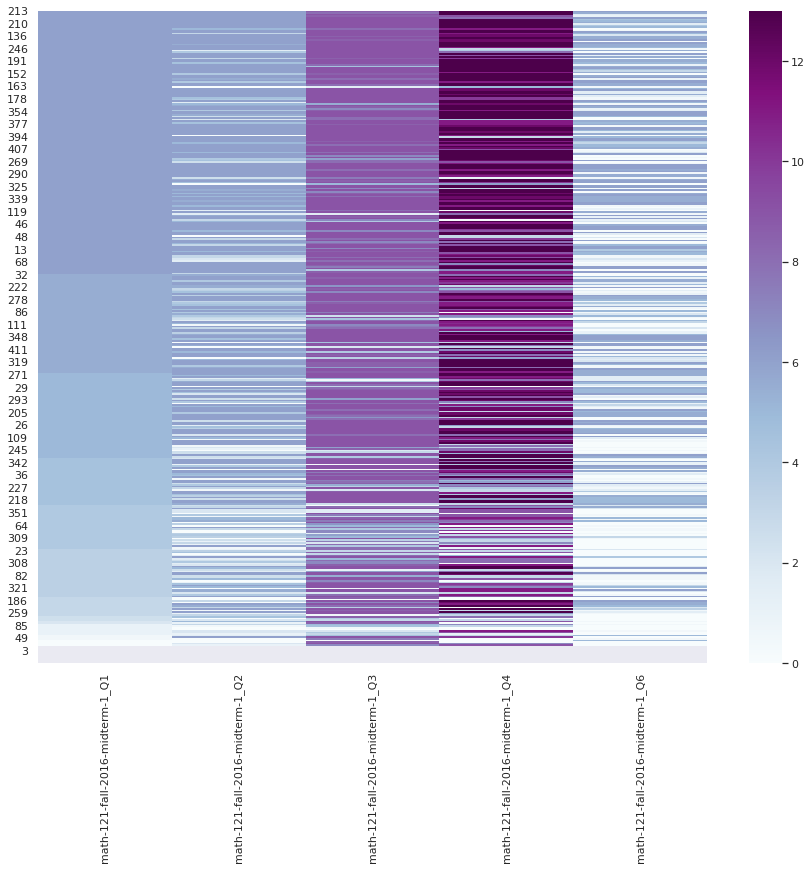

In [24]:
# Plot a score heatmap sorted on a specific column
selectedcolumn = scores.columns[0]
print('Sorted along scores for question ' + selectedcolumn)
plt.figure(figsize=(15,12))
ax =  sns.heatmap(scores.sort_values(by=[selectedcolumn], ascending = False), cmap='BuPu')

The heat map is a visual rendering of the grades-across-questions in the class. Rows in the heat map correspond to students. The heat map is sorted based on one of the columns. The column used for sorting can be changed using `selectedcolumn`. 

Some questions generate scores that vary between the minimum value (often 0) and the maximum value (often 10). The questions stratify the class. There are other questions that all or most students answer correctly and still others that all or most students answer incorrectly. The questions with scores that stratify the students appear to be most valuable in the analysis of learning performance in the class.

In [25]:
corr = scores.corr

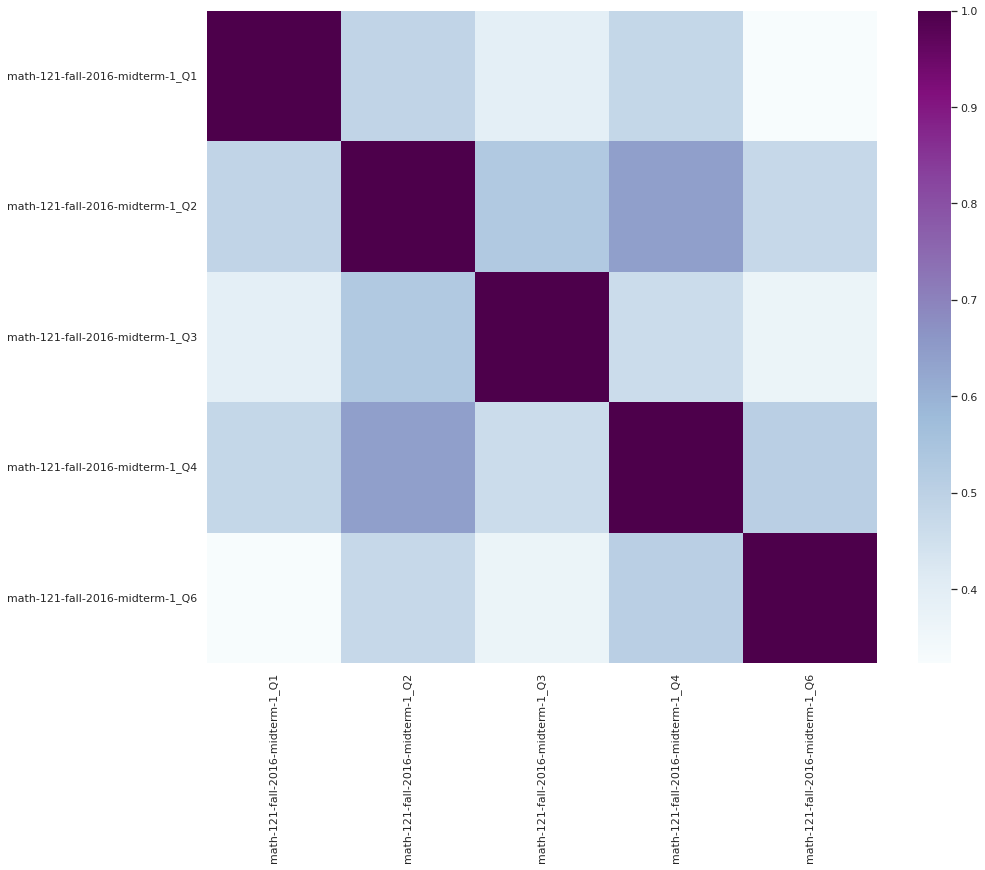

In [26]:
plt.figure(figsize = (15,12))
ax = sns.heatmap(corr('pearson'), cmap="BuPu", annot=False)

The visualization above is a heat map rendering of the correlation matrix. The questions in the analysis are listed along the edge and across the bottom. The cells correspond to a pair of questions. The correlation measure the tendency for students who do well on one of the questions also do well (a positive correlation) on the other question. It is also possible that students who do well on one question may tend to do poorly (a negative correlation) on another question. Students who do well on questions tend to well on other questions so negative correlations are rarely seen in the scores data.

### Questions Performance

In [27]:
questions = scores.columns

In [28]:
scores.describe(include=[np.number]).transpose().sort_values(by='std', ascending = False)

,count,mean,std,min,25%,50%,75%,max
math-121-fall-2016-midterm-1_Q4,405.0,9.728395,3.936257,0.0,8.0,11.0,13.0,13.0
math-121-fall-2016-midterm-1_Q6,405.0,2.825926,2.526090,0.0,0.5,2.0,5.5,6.0
math-121-fall-2016-midterm-1_Q3,405.0,7.795062,2.200354,0.0,8.0,9.0,9.0,9.0
math-121-fall-2016-midterm-1_Q2,405.0,4.440741,2.031666,0.0,3.0,5.5,6.0,6.0
math-121-fall-2016-midterm-1_Q1,405.0,5.027160,1.264717,0.0,4.5,5.5,6.0,6.0


Note: The jointplot method enables zooming into a pairwise interaction:
    sns.jointplot(x=scores['mat217-midterm-1_MT1_4'], y=scores['mat217-final_F4'], kind = "kde")

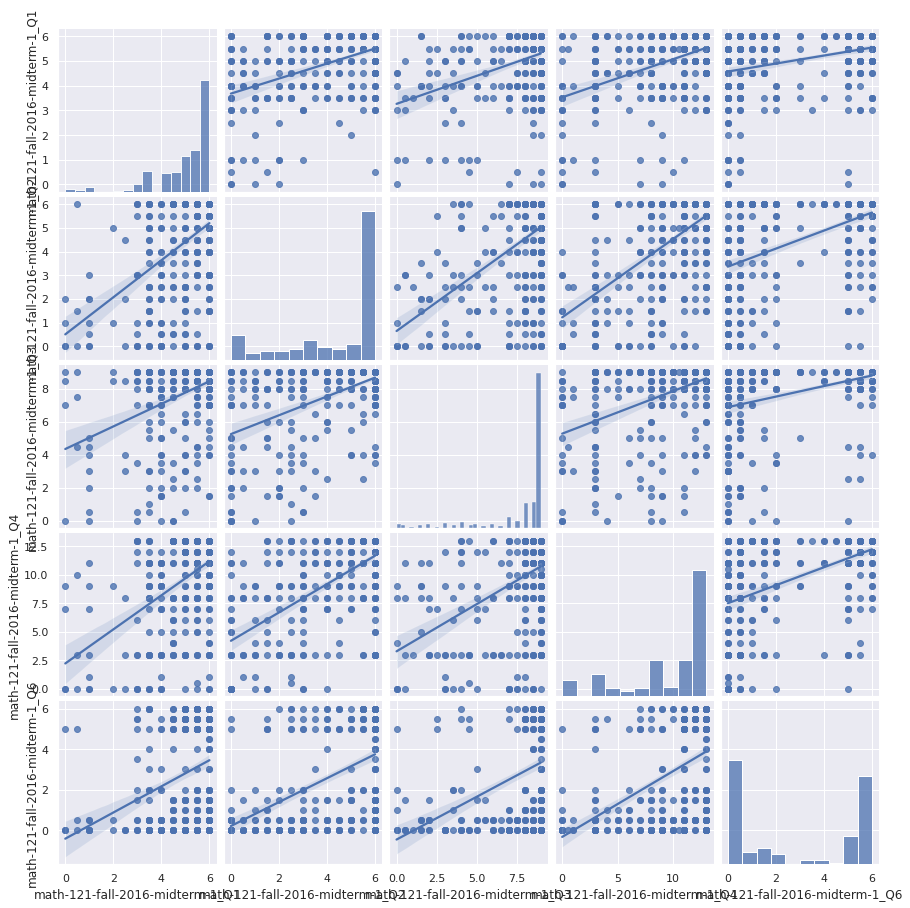

In [29]:
sns.pairplot(scores , kind = 'reg')

The visualization above is a more granular representation of the data that is computed to generate the correlation matrix. The individual cells include visualizations of the scores across the two questions that define the cell. The lines drawn through the cells convey the correlation.

The next cell generates a different rendering of the correlation matrix showing the densities (as contour maps) of students in each cell.

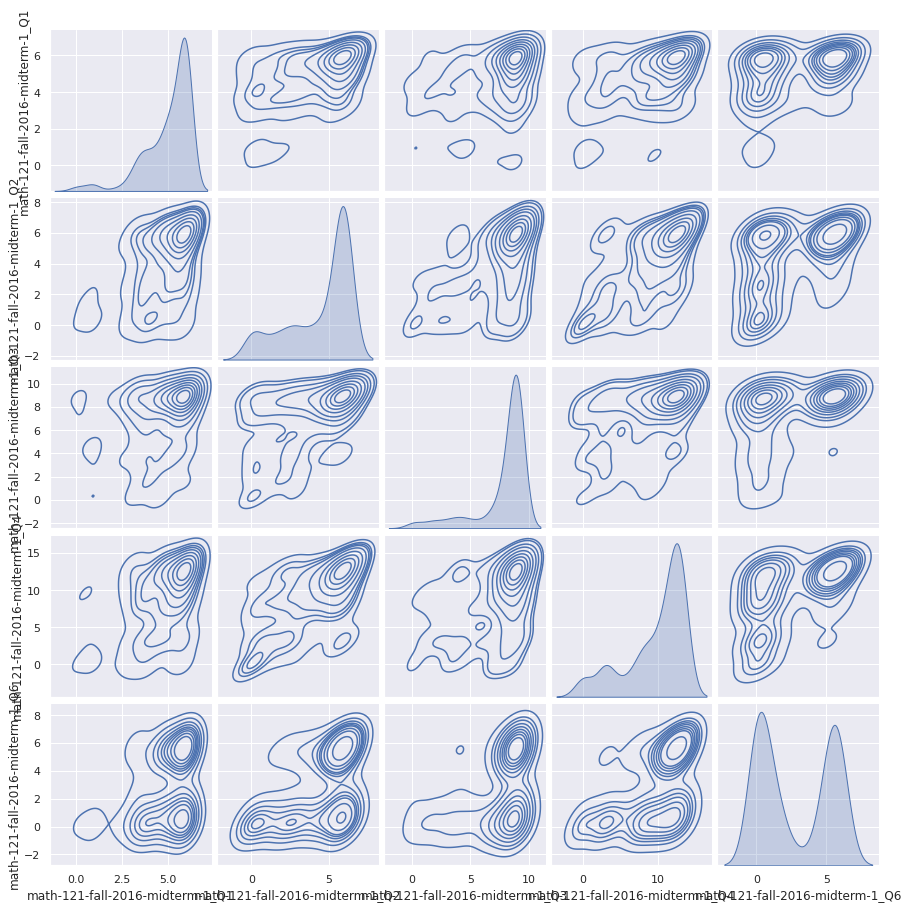

In [30]:
sns.pairplot(scores , kind = 'kde')

### Preprocess for ML

### Apply StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
scaled_scores_array = scaler.fit_transform(scores)

In [ ]:
print(scaled_scores)

In [ ]:
# Conver teh scaled scores data (in array format) back into a data frame
from pandas import DataFrame
scaled_scores = DataFrame(scaled_scores_array)

In [ ]:
scaled_scores.describe

In [ ]:
type(scaled_scores)

## PCA?

Imitate [this post](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60).

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
scaled_scores = scaled_scores.dropna()

In [ ]:
pca = PCA(n_components=5)

In [ ]:
pca_scores = pca.fit_transform(scaled_scores)
principalDf = pd.DataFrame(data = pca_scores
             , columns = ['pc1', 'pc2','pc3','pc4','pc5'])

In [ ]:
print(pca.explained_variance_ratio_)

In [ ]:
print(pca.components_)

In [ ]:
pca.components_.shape

In [ ]:
scores.shape

In [ ]:
pca.explained_variance_

In [ ]:
pca.get_covariance


In [ ]:
pca.singular_values_